## Changelog
* Added flexibility of plotting multiple settlement-time plots on same figure, including vanilla plot without PVD AND surcharge
* Default legend font size is now 'medium'. Figsize also set at (10,8)


In [ ]:
#@title Utilities

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 12 13:58:01 2021

@author: ngzicong
"""
import gc
import numpy as np
from numpy import pi,inf
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
#import xlwings as xw
import matplotlib.pylab as pylab
from scipy import spatial, integrate
params = {'legend.fontsize': 'medium',
          'figure.figsize': (6,6),
          'figure.dpi': 200,
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

#############################################################################
#functions to calc time consol curves

#finding nearest value in array and return index
def find_nearest(array, value, verbose = True):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#suitable for two-way drainage + one-way drainage with constant PWP
def Two_Way_Consol_Analytical(m_max = 1e3, color = 'k', title = None, graph = False):
    
    m = np.arange(0,m_max,1)
    M = pi*(2*m+1)/2
    Tv_min = 1/1e4
    Tv_range = np.arange(Tv_min,2,Tv_min)
    
    Uv_range = []
    for Tv in Tv_range:
        Uv = 1 - sum(2/(M**2) * np.exp(-Tv*M**2))
        Uv_range.append(Uv)
    
    if graph:
        plt.figure()
        plt.title('Terzaghi Solution (Uv vs Tv)' + title)
        plt.semilogx(Tv_range, Uv_range,
                     marker = ".",
                     color = color,)
    
        plt.xlabel('Time Factor, Tv')
        plt.ylabel('Average Degree of Consolidation')
        plt.yticks(np.arange(0,1,0.1))
        plt.grid(which = 'both',color = 'k')
        plt.axis([Tv_min,2,1,0])

    return(Uv_range,Tv_range)

#Calibrated to typical upper SMC params by default, based on mid-depth PWP
def Ult_Settlement(Po,Pf,Pc, H,e0 = 2, Cc = 0.6,Cr = 0.06, verbose = True):
    if verbose:
        print('Po = {0}kPa, Pf = {1}kPa, Pc = {2}kPa, H = {3}m'.format(Po,Pf,Pc,H))
    Po_Pc_diff = (np.abs(Pc-Po)/Po)*100
    if Po_Pc_diff < 5: #NC
        Sp = Cc/(1+e0)*H*np.log10(Pf/Po) #beware of units
        if verbose:
            print('Clay is approximately NC since % diff b/t Po and Pc is {}%'.format(Po_Pc_diff))
            print('Settlement, Sp = {}m'.format(np.around(Sp,3)))
        return Sp

    elif Po < Pc: #OC
        Sp = Cc/(1+e0)*H*np.log10(Pf/Pc) + Cr/(1+e0)*H*np.log10(Pc/Po)
        if verbose:
            print('Clay is OC')
            print('Settlement, Sp = {}m'.format(np.around(Sp,3)))
        return Sp

#function assumes surcharge is on top of design load. No factoring
#By default, finds required time t to achieve design settlement under given surcharge
#Time interval based on per day
#If input duration (years), equivalent Uv is returned
#cv to be in m^2/year
def Req_Surcharge_Consol_U(surcharge,Po,Pf,Pc, H, duration = False, 
                           e0 = 2, Cc = 0.6,Cr = 0.06, cv = 0.5,double_drain = True, 
                           graph = False, title = None, verbose = True):

    if double_drain: #double drainage
        d = H/2
    else:
        d = H
    
    if duration:
        
        Uv_range,Tv_range = Two_Way_Consol_Analytical(graph = graph, title = title)
        Uv_list = []
        for time in np.arange(0,duration,np.around(1/(duration*365),6)):
            Tv = cv*time/(d**2)
            Uv = Uv_range[find_nearest(Tv_range,Tv)]
            Uv_list.append(Uv)
        Tv_final = cv*duration/(d**2)
        Uv_final = Uv_range[find_nearest(Tv_range,Tv_final)]
        Uv_list.append(Uv_final)
        if graph:
            plt.plot(Tv_final,Uv_final, color='green', linestyle='dashed', marker='o',markerfacecolor='red', markersize=15)
        if verbose:
            print('For settlement duration of {0} years, expected Uv = {1}%'.format(duration,np.around(Uv,3)*100))
            
        if verbose:
            print('Applying {}kPa surcharge\n'.format(surcharge))
            print('Calculating design settlement...')
        S_design = Ult_Settlement(Po,Pf,Pc, H,e0 = e0, Cc = Cc,Cr = Cr, verbose = verbose)
        if verbose:
            print('Calculating ultimate settlement WITH surcharge...')
        S_surcharge = Ult_Settlement(Po,Pf + surcharge,Pc, H,e0 = e0, Cc = Cc,Cr = Cr, verbose = verbose)
        
        Uv_ult = S_design/S_surcharge #given surcharge required to reach this level of consol
        if verbose:
            print('\nUnder {0}kPa surcharge, required degree of consolidation is {1}%'.format(surcharge,np.around(Uv*100,1)))
            print('Using Terzaghi avg degree of consol chart to find Tv')
        idx = find_nearest(Uv_range,Uv_ult)
        No_PVD_Tv_list, No_PVD_Uv_list = Tv_range[0:idx],Uv_range[0:idx]
        return Uv, Uv_list, No_PVD_Tv_list, No_PVD_Uv_list
      
    else:
        if verbose:
            print('Applying {}kPa surcharge\n'.format(surcharge))
            print('Calculating design settlement...')
        S_design = Ult_Settlement(Po,Pf,Pc, H,e0 = e0, Cc = Cc,Cr = Cr, verbose = verbose)
        if verbose:
            print('Calculating ultimate settlement WITH surcharge...')
        S_surcharge = Ult_Settlement(Po,Pf + surcharge,Pc, H,e0 = e0, Cc = Cc,Cr = Cr, verbose = verbose)

        Uv = S_design/S_surcharge #given surcharge required to reach this level of consol
        if verbose:
            print('\nUnder {0}kPa surcharge, required degree of consolidation is {1}%'.format(surcharge,np.around(Uv*100,1)))
            print('Using Terzaghi avg degree of consol chart to find Tv')

        Uv_range,Tv_range = Two_Way_Consol_Analytical(graph = graph)
        idx = find_nearest(Uv_range,Uv)
        Tv, Uv = Tv_range[idx],Uv_range[idx]
        if graph:
            plt.plot(Tv,Uv, color='green', linestyle='dashed', marker='o',markerfacecolor='red', markersize=15)
            plt.show()
        t_years = Tv*(d**2)/cv #years
        if verbose:
            print('Under given surcharge, required settlement time before removal is {} months'.format(t_years*12))
        return Uv, t_years
        
        
    
    

def Barron_Soln(n_given = 31.8,color = 'k', title = None, graph = False):
    Th_min = 1/1e4
    Th_range = np.arange(Th_min,2,Th_min)
    
    if n_given:
        m = (n_given**2)/(-1+n_given**2)*np.log(n_given) - (-1+3*n_given**2)/(4*(n_given**2))
        #m = np.log(n_given) - 3/4
        Uh_range = 1 - np.exp((-8*Th_range)/m)
        
    if graph:
        plt.figure()
        plt.title('Barron Solution (Uh vs Th)' + title)
        plt.semilogx(Th_range, Uh_range,
                     marker = ".",
                     color = color,)
        plt.xlabel('Time Factor, Th')
        plt.ylabel('Average Degree of Consolidation')
        plt.yticks(np.arange(0,1,0.1))
        plt.grid(which = 'both',color = 'k')
        plt.axis([Th_min,2,1,0])

    return(Uh_range,Th_range)

def PVD_equiv_dim(length,width):
    d_equiv = 2*(length+width)/pi
    return d_equiv

#Calculates settlement given duration and plot settlement rate
#Duration is the time of which additional surcharge is placed
def PVD_given_duration(length,width,spacing,surcharge,Po,Pf,Pc,H,duration = False, 
                       pattern = 'triangular',smear = 0.8,e0 = 2, 
                       Cc = 0.6,Cr = 0.06, cv = 0.5, ch = 1.5, double_drain = True, add = 0.5,
                       graph = True, axis = False, new = True, main_color = 'k', legend = True,
                       Uv_graph = False, Uh_graph = False, 
                       Uv_verbose = True, Uh_verbose = True):
    print('PVD length = {0}m, PVD width = {1}m'.format(length,width))
    print('PVD spacing = {0}m based on {1} pattern'.format(spacing,pattern))
    print('Po = {0}kPa, Pf = {1}kPa, Pc = {2}kPa, H = {3}m'.format(Po,Pf,Pc,H))
    print('Surcharge = {0}kPa applied for {1} years\n'.format(surcharge,duration))
    d_equiv = PVD_equiv_dim(length, width)*smear

    if Uh_verbose:
        print('Calculated d_equiv = {0}mm with included smearing effect factor = {1}'.format(np.around(d_equiv*1000,3),smear))

    #Calc design settlement & No PVD & no surcharge settlement
    S_design = Ult_Settlement(Po, Pf, Pc, H,e0 = e0, Cc = Cc, Cr = Cr, verbose = False)
    
    if Uv_verbose or Uh_verbose:    
        print('Design settlement is {}m'.format(np.around(S_design,3)))
        
    #Calc Uv
    No_PVD_Consol_info = Req_Surcharge_Consol_U(surcharge, Po, Pf, Pc, H, duration = duration,
                                                e0 = e0, Cc = Cc,Cr = Cr, double_drain = double_drain, 
                                                graph = Uv_graph, title = ' - Surcharge', verbose = False)
    Uv = No_PVD_Consol_info[0]
    Uv_list = No_PVD_Consol_info[1]
    S_surcharge = Ult_Settlement(Po,Pf + surcharge,Pc, H,e0 = e0, Cc = Cc,Cr = Cr, verbose = False)
    if Uv_verbose: 
        print('\nUv_settlement calculation...')
        print('For duration of {0} years, Uv = {1}%'.format(duration,np.around(Uv,3)*100))
    
    #Obtaining vanilla settlement-time
    if surcharge > 0:
        No_PVD_sur_Consol_info = Req_Surcharge_Consol_U(0, Po, Pf, Pc, H, duration = duration,
                                                        e0 = e0, Cc = Cc,Cr = Cr, double_drain = double_drain, 
                                                        graph = Uv_graph, title = ' - Surcharge', verbose = False)
    elif surcharge == 0:
        No_PVD_sur_Consol_info = No_PVD_Consol_info
        
    #Calc Uh
    if pattern == 'triangular':
        cell_D = 1.05*spacing
    elif pattern == 'square':
        cell_D = 1.128*spacing
        
    n_given = cell_D/d_equiv
    if Uh_verbose:
        print('\nUh_settlement calculation...')
        print('Calculated n = {}'.format(np.around(n_given,2)))
        
    Uh_range, Th_range = Barron_Soln(n_given = n_given, title = ' - Surcharge', graph = Uh_graph)
    
    Uh_list = []
    for time in np.arange(0,duration,np.around(1/(duration*365),6)):
        Th = ch*time/(cell_D**2)
        Uh = Uh_range[find_nearest(Th_range,Th)]
        Uh_list.append(Uh)
    Th_final = ch*duration/(cell_D**2)
    Uh_final = Uh_range[find_nearest(Th_range,Th_final)]
    Uh_list.append(Uh_final)
    if Uh_graph:
        plt.plot(Th_final,Uh_final, color='green', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=15)
    if Uh_verbose:    
        print('For duration of {0} years, Uh = {1}%'.format(duration,np.around(Uh,3)*100))
    #Calc Uvh
    Uvh_list = 1 - (1-np.asarray(Uv_list))*(1-np.asarray(Uh_list))
    t_list = np.append(np.arange(0,duration,np.around(1/(duration*365),6)),duration)
    
    #Calc expected settlement and residual
    S_expected = S_surcharge*Uvh_list[-1]
    S_residual = S_design - S_expected
    if S_residual < 0:
        print('Surcharge is too high or applied for too long! Residual settlement is negative')

    if Uv_verbose or Uh_verbose:
        print('Expected settlement = {0}m in {1} years. Residual settlement = {2}m'.format(np.around(S_expected,3),
                                                                                         duration,
                                                                                         np.around(S_residual,3)))
    
    Svh_list = Uvh_list*S_surcharge #m
    Svh_list_sur, t_list_sur = Svh_list, t_list #backup
    
    #Calc required additional time after removing surcharge
    no_surcharge = 0 #removed
    #Based on Uvh_final, calculate state of consolidation and new Po'
    Po = Po + Uvh_list[-1]*(Pf+surcharge-Po)
    if Po > Pc:
        Pc = Po #NC clay
    if Uv_verbose and surcharge != 0:
        print('\nSurcharge is removed after {0}years.\nBased on Uvh = {1}%, Po = {2}kPa'.format(duration,
                                                                                             np.around(Uvh_list[-1],2)*100,
                                                                                             np.around(Po,2)))
    elif Uv_verbose and surcharge ==0:
        print('\nNo surcharge applied. Continuing calculation of settlement behaviour after {} years'.format(duration))
    #Recalculate Uv and Uh
    #Calc Uv
    if Uv_verbose and surcharge > 0:
        if S_residual < 0:
            print('Recalculating rebound time based on Po = {}kPa while Pf is unchanged'.format(np.around(Po,2)))
        else:
            print('Recalculating additional time required to reach design settlement using Po = {}kPa'.format(np.around(Po,2)))
            
    elif Uv_verbose and surcharge == 0:
        print('Calculating additional time required to reach design settlement using Po = {}kPa'.format(np.around(Po,2)))
        
    No_PVD_Consol_info = Req_Surcharge_Consol_U(no_surcharge, Po, Pf, Pc, H, duration = add*duration,
                                                e0 = e0, Cc = Cc,Cr = Cr, double_drain = double_drain, 
                                                graph = Uv_graph, title = ' - Post-Surcharge', verbose = False)
    Uv = No_PVD_Consol_info[0]
    Uv_list = No_PVD_Consol_info[1]
    #Calc Uh    
    Uh_list = []
    #Calculate equiv dimensionless time for given time range
    for time in np.arange(0,add*duration,np.around(1/(add*duration*365),6)):
        Th = ch*time/(cell_D**2)
        Uh = Uh_range[find_nearest(Th_range,Th)]
        Uh_list.append(Uh)
    Th_final = ch*duration/(cell_D**2)
    Uh_final = Uh_range[find_nearest(Th_range,Th_final)]
    Uh_list.append(Uh_final)
    Barron_Soln(n_given = n_given, graph = Uh_graph, title = ' - Post-Surcharge')
    if Uh_graph:
        plt.plot(Th_final,Uh_final, color='green', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=15)
    #Calc Uvh and Svh
    Uvh_list = 1 - (1-np.asarray(Uv_list))*(1-np.asarray(Uh_list))
    t_list = np.append(np.arange(duration,add*duration + duration,np.around(1/(add*duration*365),6)),duration + add*duration)
    Svh_list = Uvh_list*S_residual + S_expected
    

    if graph:
        if (Uv_verbose or Uh_verbose) and surcharge > 0:
            print('\nReferring to graph...\nSolid segment refers to main settlement path under surcharge, dotted segment refers to post-surcharge settlement path/rebound')
        elif (Uv_verbose or Uh_verbose) and surcharge == 0:
            print('\nReferring to graph...\nSolid segment refers to main settlement path, dotted segment refers to residual settlement')
            
        if new:
            plt.figure(figsize = (10,8)) 
        surcharge_line = plt.plot(t_list_sur*12, Svh_list_sur*1000, 
                                  label = 'Main Settlement Path, surcharge = {0}kPa\nt = {1} months'.format(surcharge,duration*12),
                                  marker ='.', color = main_color)
        no_surcharge_line = plt.plot(t_list*12, Svh_list*1000, '--',
                                     label = 'Residual Settlement Path,surcharge = {0}kPa\nt = {1} months'.format(surcharge,duration*12),  
                                     color = main_color, lw = 2) 

        No_PVD_sur_t_list = np.append(np.arange(0,add*duration + duration,np.around(1/(add*duration*365),6)),duration + add*duration)
        No_PVD_sur_Sv_list = S_design*np.asarray(No_PVD_sur_Consol_info[3][0:len(No_PVD_sur_t_list)])
        vanilla_line = plt.plot(No_PVD_sur_t_list*12, No_PVD_sur_Sv_list*1000, ':',
                                label = 'Original Settlement Path (no PVD & surcharge)',
                                color = 'k', lw = 2)
        
        plt.title('Settlement vs Time Plot')
        plt.xlabel('Time (months)')
        plt.ylabel('Settlement (mm)')
        if axis:
            plt.axis([0,(duration+add*duration)*12, S_surcharge*1000*1.05,0.])

        
        #labelling surcharge end point
        plt.hlines(S_expected*1000,0,duration*12, colors = 'green', linestyles = 'dashed', lw = 2)
        plt.vlines(duration*12, S_expected*1000, S_surcharge*10000, colors = 'green', linestyles = 'dashed', lw = 2) #extra long to touch x axis
        if S_residual > 0:
            plt.annotate('Expected Settlement:{0}mm\nResidual Settlement:{1}mm'.format(int(S_expected*1000),int(S_residual*1000)),
                         (duration*12, S_expected*1000),(duration*12*1.05,S_expected*1000*0.93), 
                         arrowprops=dict(arrowstyle='<-', color='green', linewidth=2))
        elif S_residual < 0:
            plt.annotate('Expected Settlement:{0}mm\nResidual Settlement:{1}mm'.format(int(S_expected*1000),int(S_residual*1000)),
                         (duration*12, S_expected*1000),(duration*12*1.2,S_expected*1000*1.1), 
                         arrowprops=dict(arrowstyle='<-', color='green', linewidth=2))
        #design settlement limit
        design_line = plt.hlines(S_design*1000,0,(duration+add*duration)*12, 
                                 label = 'Design Settlement', 
                                 colors = 'blue', linestyles = 'dashed', lw = 2)
        plt.annotate(' {0}mm'.format(int(S_design*1000)),
                     (0, S_design*1000),(0,S_design*1000*0.98))
        
        #Display additional information
        if legend:
            plt.legend(handles=[surcharge_line[0], no_surcharge_line[0], design_line], loc = 'best')
        
        return [(S_design, S_expected, S_residual, S_surcharge),surcharge_line[0], no_surcharge_line[0], vanilla_line[0], design_line]
    return (S_design, S_expected, S_residual, S_surcharge)


PVD length = 0.1m, PVD width = 0.005m
PVD spacing = 1.5m based on square pattern
Po = 36kPa, Pf = 93kPa, Pc = 36kPa, H = 12m
Surcharge = 0kPa applied for 0.5 years

Calculated d_equiv = 53.476mm with included smearing effect factor = 0.8
Design settlement is 1.409m

Uv_settlement calculation...
For duration of 0.5 years, Uv = 9.4%

Uh_settlement calculation...
Calculated n = 31.64
For duration of 0.5 years, Uh = 64.3%
Expected settlement = 0.954m in 0.5 years. Residual settlement = 0.455m

No surcharge applied. Continuing calculation of settlement behaviour after 0.5 years
Calculating additional time required to reach design settlement using Po = 74.59kPa

Referring to graph...
Solid segment refers to main settlement path, dotted segment refers to residual settlement
PVD length = 0.1m, PVD width = 0.005m
PVD spacing = 1.5m based on square pattern
Po = 36kPa, Pf = 93kPa, Pc = 36kPa, H = 12m
Surcharge = 50kPa applied for 0.5 years

Calculated d_equiv = 53.476mm with included smearing eff

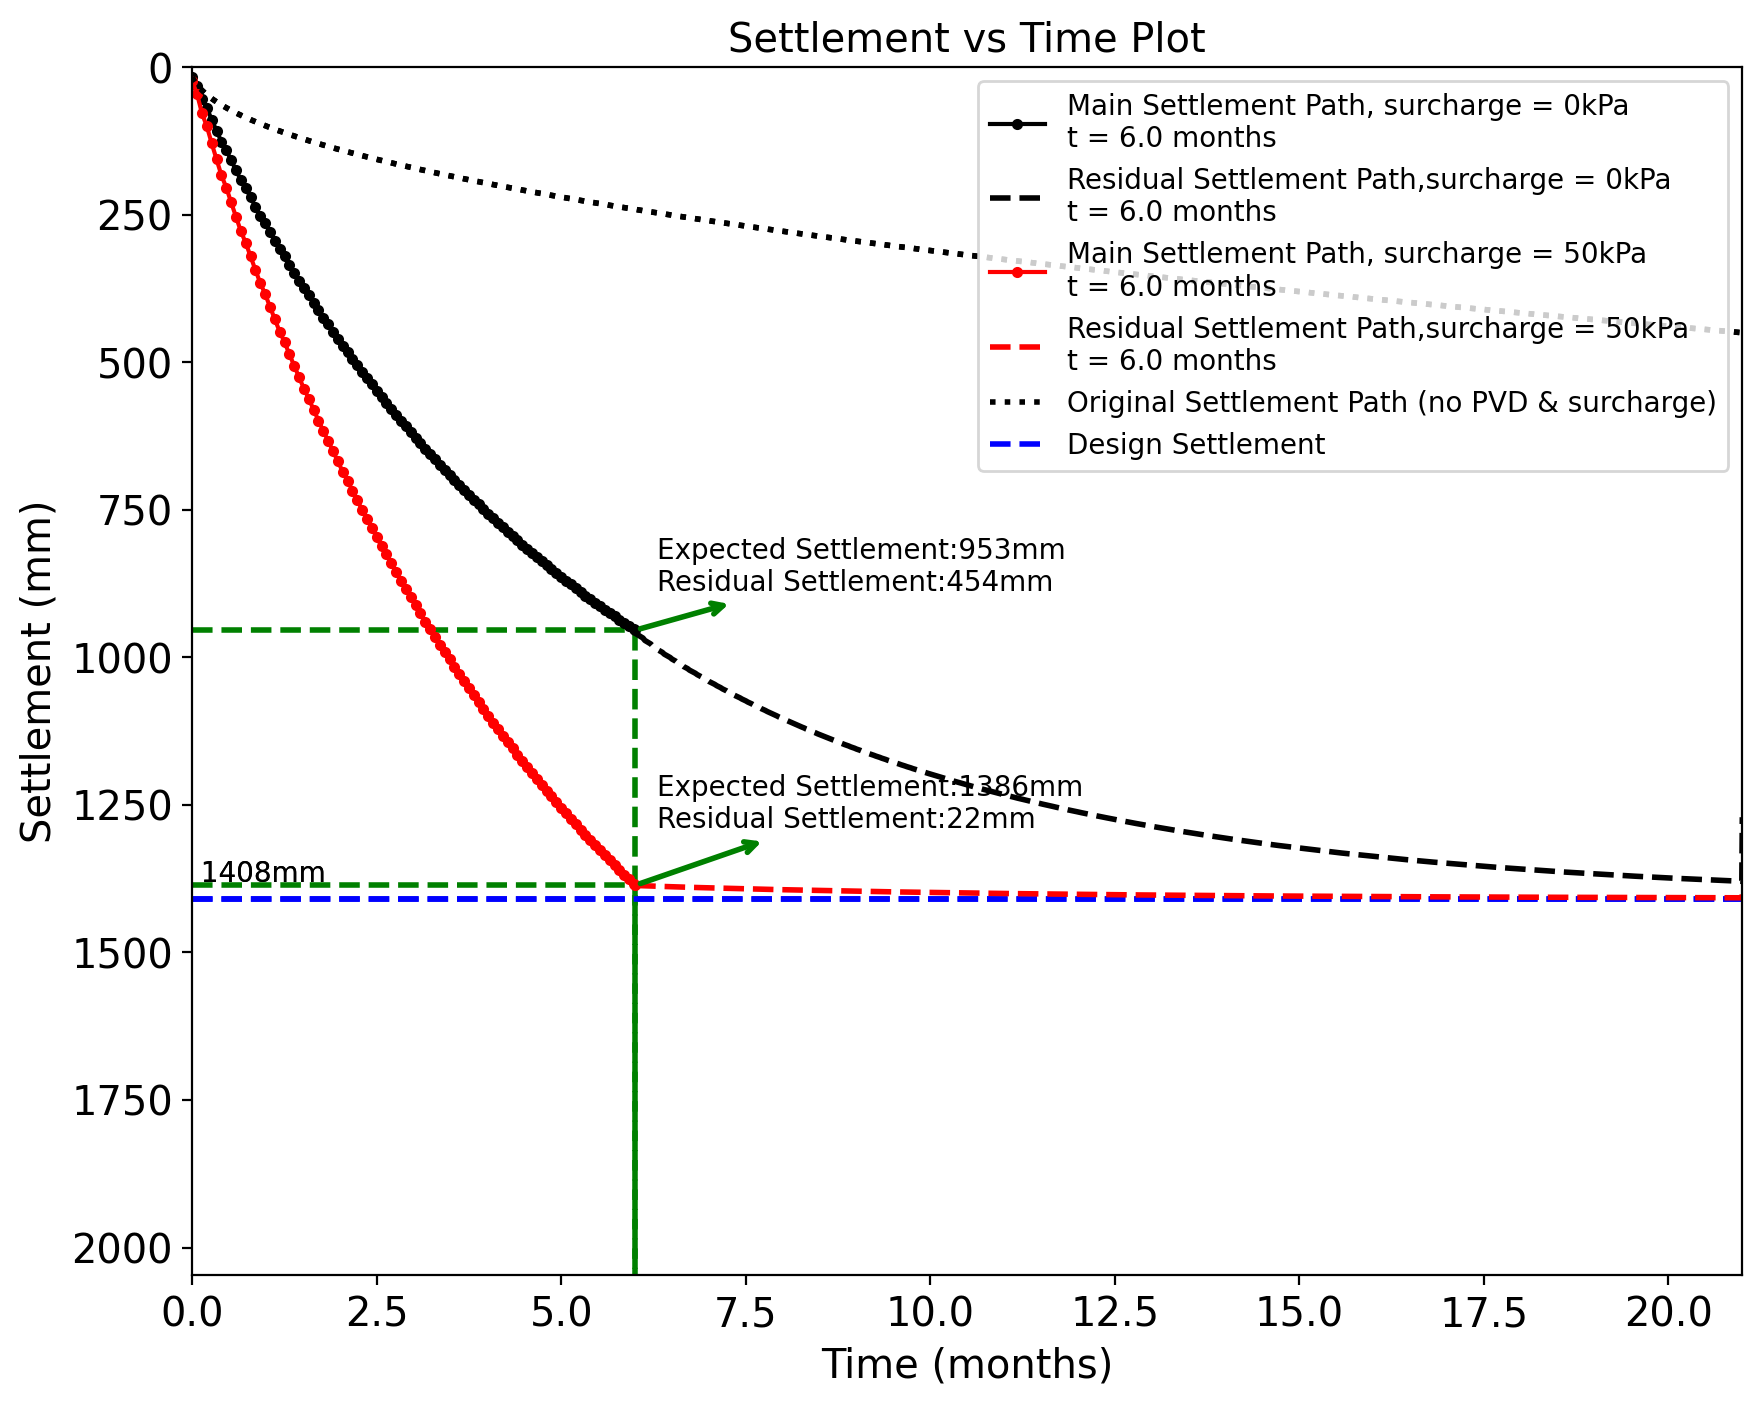

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 22 23:41:50 2021

@author: ngzicong
"""
###################################################################################################
#Testing using lecture example on slides 102++
#Edit soil params here
###################################################################################################
surcharge = 0 #kPa
duration = 0.5 #years of which surcharge is applied
length = 0.1 #m, PVD strip long side
width = 5e-3 #m, PVD strip short side
spacing = 1.5 #m c/c spacing
pattern = 'square' #arrangement
smear = 0.8 #smearing factor

#Strata thickness, initial and final effective stresses
#and double drain condition validity
H = 12 #m
Po, Pf = 36,93 #kPa 
double_drain = True #if mudstone/stiff clay base, set to False

#Soil consolidation properties
Pc = Po #kPa, Assumed NC in this case
e0 = 2.16
Cc = 0.9
Cr = 0.06
cv = 1 #m^2/year
ch = 2 #m^2/year

#Graph display #toggle True if needed
Uv_graph = False #Annotated Terzaghi plot
Uh_graph = False #Annotated Barron plot
graph = True #for settlement time plot
add = 2.5 #extra add*duration to observe residual settlement path 


Settlement_Time_1 = PVD_given_duration(length, width, 
                                       spacing, surcharge, 
                                       Po, Pf, Pc, H, 
                                       pattern = pattern, e0 = e0, Cc = Cc, Cr = Cr, cv = cv, ch = ch,
                                       smear = smear, duration = duration, double_drain = double_drain, add = add,
                                       Uv_graph = Uv_graph, Uh_graph = Uh_graph, 
                                       graph = graph, main_color = 'k', legend = False)

Settlement_Time_2 = PVD_given_duration(length, width, 
                                       spacing, 50, 
                                       Po, Pf, Pc, H, 
                                       pattern = pattern, e0 = e0, Cc = Cc, Cr = Cr, cv = cv, ch = ch,
                                       smear = smear, duration = duration, double_drain = double_drain, add = add,
                                       Uv_graph = Uv_graph, Uh_graph = Uh_graph, 
                                       graph = graph, new = False, main_color = 'r', legend = False)

#Settlement_Time_n = [(S_design, S_expected, S_residual, S_surcharge),surcharge_line[0], no_surcharge_line[0], design_line]

S_surcharge = max(Settlement_Time_1[0][-1],Settlement_Time_2[0][-1])
plt.axis([0,(duration+add*duration)*12, S_surcharge*1000,0.])
plt.legend(handles=[Settlement_Time_1[1],Settlement_Time_1[2], 
                    Settlement_Time_2[1], Settlement_Time_2[2],Settlement_Time_2[3], Settlement_Time_2[-1]], 
           loc = 'upper right')
plt.show()